In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Projects/Emotion Recognizer/Emotion Recognition Dataset.zip'

Streaming output truncated to the last 5000 lines.
 extracting: Emotion Recognition/train/sad/Training_65267116.jpg  
 extracting: Emotion Recognition/train/sad/Training_65275626.jpg  
 extracting: Emotion Recognition/train/sad/Training_6529266.jpg  
 extracting: Emotion Recognition/train/sad/Training_65329617.jpg  
 extracting: Emotion Recognition/train/sad/Training_65338712.jpg  
 extracting: Emotion Recognition/train/sad/Training_65338797.jpg  
 extracting: Emotion Recognition/train/sad/Training_65387162.jpg  
 extracting: Emotion Recognition/train/sad/Training_65404494.jpg  
 extracting: Emotion Recognition/train/sad/Training_65426218.jpg  
 extracting: Emotion Recognition/train/sad/Training_65430136.jpg  
 extracting: Emotion Recognition/train/sad/Training_65437377.jpg  
 extracting: Emotion Recognition/train/sad/Training_6545735.jpg  
 extracting: Emotion Recognition/train/sad/Training_65463385.jpg  
 extracting: Emotion Recognition/train/sad/Training_65473985.jpg  
 extracting: 

In [ ]:
# import os
# import shutil

# shutil.move('/content/drive/MyDrive/Emotion Recognition','/content/drive/MyDrive/Projects/Emotion Recognizer')

In [ ]:
# os.chdir('/content/drive/MyDrive/Projects/Emotion Recognizer')
# for _, _, filenames in os.walk('.'):
#     for filename in filenames:
#         if filename[-3:]=='zip':
#             os.remove(filename)

# os.listdir('.')

['EmotionRecognition.ipynb', 'Emotion Recognition']

In [ ]:
# os.rename('Emotion Recognition','data')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import cv2

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.applications.resnet_v2 import ResNet50V2,  preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

def warn(*args,**kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

os.chdir('/content/drive/MyDrive/Projects/Emotion Recognizer')

In [ ]:
emotions = ['angry','disgust','fear','happy','neutral','sad','surprise']
print(emotions)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
train_img_cnt = []
for emot in emotions:
    print(f"No. of '{emot}' train images: {len(os.listdir('data/train/'+emot))}")
    train_img_cnt.append(len(os.listdir('data/train/'+emot)))

No. of 'angry' train images: 3995
No. of 'disgust' train images: 436
No. of 'fear' train images: 4097
No. of 'happy' train images: 7215
No. of 'neutral' train images: 4965
No. of 'sad' train images: 4830
No. of 'surprise' train images: 3171


In [ ]:
test_img_cnt = []
for emot in emotions:
    print(f"No. of '{emot}' train images: {len(os.listdir('data/test/'+emot))}")
    test_img_cnt.append(len(os.listdir('data/test/'+emot)))

No. of 'angry' train images: 958
No. of 'disgust' train images: 111
No. of 'fear' train images: 1024
No. of 'happy' train images: 1774
No. of 'neutral' train images: 1233
No. of 'sad' train images: 1247
No. of 'surprise' train images: 831


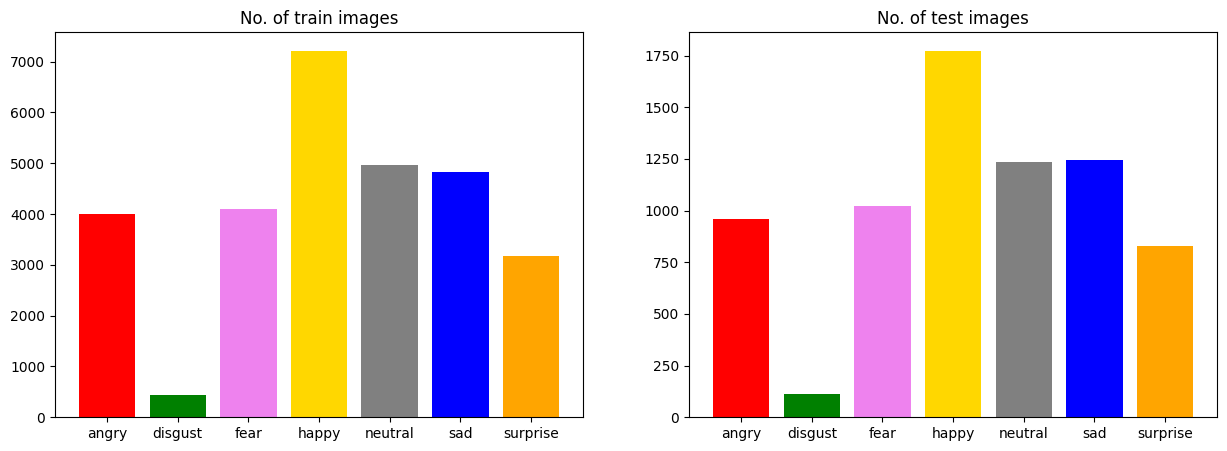

In [ ]:
colors = ['r','g','violet','gold','gray','b','orange']
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(emotions,train_img_cnt,color=colors)
ax[0].set_title('No. of train images')
ax[1].bar(emotions,test_img_cnt,color=colors)
ax[1].set_title('No. of test images');

In [ ]:
data = []

for emot in emotions:
    path = os.path.join('data/train',emot)
    label = emotions.index(emot)
    for filename in os.listdir(path):
        img_path = os.path.join(path,filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img,(48,48))
        data.append([img,label])

data = np.array(data)

In [ ]:
X = []
y = []
for image, label in data:
    X.append(image)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(X.shape,y.shape)

(28709, 48, 48, 3) (28709,)


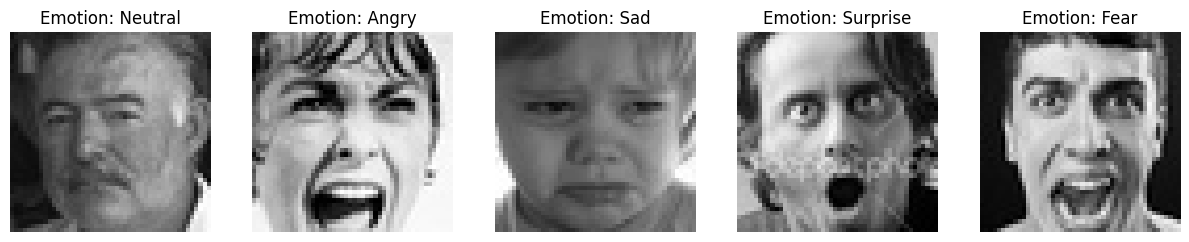

In [ ]:
plt.figure(figsize=(12,5))
for i in range(1,6):
    plt.subplot(1,5,i)
    rand_num = np.random.randint(0,28273)
    plt.imshow(X[rand_num])
    plt.title(f"Emotion: {emotions[y[rand_num]].capitalize()}")
    plt.tight_layout()
    plt.axis('off');

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1.0/255)
validation_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_data_gen.flow_from_directory(
    'data/train',
    target_size = (48,48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = validation_data_gen.flow_from_directory(
    'data/test',
    target_size = (48,48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
model = Sequential([
                Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1),padding='same'),
                Conv2D(64, kernel_size=(3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Dropout(0.25),

                Conv2D(128, kernel_size=(3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Conv2D(128, kernel_size=(3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Dropout(0.25),

                Flatten(),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')]
                   )

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

In [ ]:
opt = Adam(lr=0.0001,decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Epoch 1/15
448/448 [==============================] - 68s 149ms/step - loss: 1.8131 - accuracy: 0.2503 - val_loss: 1.7510 - val_accuracy: 0.2871
Epoch 2/15
448/448 [==============================] - 56s 125ms/step - loss: 1.6624 - accuracy: 0.3454 - val_loss: 1.5702 - val_accuracy: 0.4096
Epoch 3/15
448/448 [==============================] - 66s 147ms/step - loss: 1.5588 - accuracy: 0.4006 - val_loss: 1.5240 - val_accuracy: 0.4180
Epoch 4/15
448/448 [==============================] - 55s 124ms/step - loss: 1.4914 - accuracy: 0.4260 - val_loss: 1.4305 - val_accuracy: 0.4623
Epoch 5/15
448/448 [==============================] - 55s 123ms/step - loss: 1.4305 - accuracy: 0.4547 - val_loss: 1.3931 - val_accuracy: 0.4668
Epoch 6/15
448/448 [==============================] - 55s 123ms/step - loss: 1.3775 - accuracy: 0.4750 - val_loss: 1.3632 - val_accuracy: 0.4801
Epoch 7/15
448/448 [==============================] - 66s 148ms/step - loss: 1.3336 - accuracy: 0.4925 - val_loss: 1.2954 - val_ac

In [ ]:
model_json = model.to_json()
with open("emotion_model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save('emotion_recognizer.h5')